# Natural Language Processing to detect offensive language in Social Media Posts Using OLID Dataset



## Load all the required Libraries
Note that NLTK libs require downloads. Some of the libraries like Indic-Bert require loading as well. 

In [1]:
#All library imports are here
import numpy as np
import pandas as pd
import re
import string
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import keras
import tensorflow as tf
import tensorflow.python.keras.backend as K
from tensorflow.python.client import device_lib
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from sklearn.metrics import make_scorer, f1_score, accuracy_score, recall_score, precision_score, classification_report, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras.layers.core import Dense, Dropout, Activation, Lambda
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Set GPU or CPU
Set the Jupyter Notebook to execute in GPU or CPU based on availability
For the purpose of this project, I have used an NVIDIA GPU 3060 with 12GB GPU Memory and an Intel 12th Generation Desktop CPU with 16GB RAM

In [2]:
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')


We are using device name "cuda"


## Functions for cleanup of OLID Dataset

In [4]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def myclean(mytext):
    mytext = str(mytext)
    cleantext = str(mytext.encode('ascii'))
    cleantext.encode('unicode-escape').decode()
    return cleantext


#Function to clean tweets in a data frame's tweet column
from cleantext import clean
def clean_tweets(df):
    
    punctuations = string.punctuation
    
    df.loc[:, 'tweet'] = df.tweet.str.replace('@USER', '') #Remove mentions (@USER)
    df.loc[:, 'tweet'] = df.tweet.str.replace('URL', '') #Remove URLs
    df.loc[:, 'tweet'] = df.tweet.str.replace('&amp', 'and') #Replace ampersand (&) with and
    df.loc[:, 'tweet'] = df.tweet.str.replace('&lt','') #Remove &lt
    df.loc[:, 'tweet'] = df.tweet.str.replace('&gt','') #Remove &gt
    df.loc[:, 'tweet'] = df.tweet.str.replace('\d+','') #Remove numbers
    df.loc[:, 'tweet'] = df.tweet.str.replace('\,','') #Remove numbers
    df.loc[:, 'tweet'] = df.tweet.str.replace('#[A-Za-z0-9_]+','') #Remove hashtags
    df = df[list(df.columns[~df.columns.duplicated()])]

    #Remove punctuations
    for punctuation in punctuations:
        df.loc[:, 'tweet'] = df.tweet.str.replace(punctuation, '')
   
    #df.loc[:, 'tweet'] = df.tweet.str.replace('[^A-Za-z0-9]', '', flags=re.UNICODE)
    #try:
    #   df.loc[:, 'tweet'] = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('unicode'))
    #except ValueError:
    #    pass
    #try:
    df.loc[:, 'tweet'] = df.astype(str).apply(lambda x: clean(x))
    df.loc[:, 'tweet'] = df.astype(str).apply(lambda x: myclean(x))
    #except TypeError:
    #    pass
    df.loc[:, 'tweet'] = df.tweet.str.strip() #Trim leading and trailing whitespaces

## Dataset file from the paper
The dataset was found along with the paper in the implementation. This was downloaded from here:
https://github.com/SilentFlame/AggressionDetection 

In [34]:
dataset_file = './olid-training-v1.0.tsv.txt'

## Read Dataset
First read the dataset file and use Pandas to convert the dataset CSV to a dataframe
The dataset consists of 3 columns and 12,000 records

In [35]:
## Use Pandas to read

train_data = pd.read_csv(dataset_file,sep = '\t')
#print(train_data)

train_data['subtask_b'] = train_data['subtask_b'].replace(["UNT","TIN"],["CAG","OAG"]) 
train_data['subtask_b'] = train_data['subtask_b'].fillna("NAG")

#print(train_data)
clean_tweets(train_data)
#print(train_data)

train_data.rename(columns={"tweet":"post", "subtask_b":"label"}, inplace = True)
print(train_data)


C:\Users\nikhi\AppData\Local\Temp\ipykernel_20228\4258680897.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, 'tweet'] = df.tweet.str.replace('\d+','') #Remove numbers
C:\Users\nikhi\AppData\Local\Temp\ipykernel_20228\4258680897.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, 'tweet'] = df.tweet.str.replace('\,','') #Remove numbers
C:\Users\nikhi\AppData\Local\Temp\ipykernel_20228\4258680897.py:44: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, 'tweet'] = df.tweet.str.replace('#[A-Za-z0-9_]+','') #Remove hashtags
C:\Users\nikhi\AppData\Local\Temp\ipykernel_20228\4258680897.py:49: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.loc[:, 'tweet'] = 

          id                                               post subtask_a  \
0      86426   She should ask a few native Americans what th...       OFF   
1      90194                   Go home you’re drunk!!!    👊🇺🇸👊        OFF   
2      16820  Amazon is investigating Chinese employees who ...       NOT   
3      62688   Someone should'veTaken" this piece of shit to...       OFF   
4      43605    Obama wanted liberals and; illegals to move ...       NOT   
...      ...                                                ...       ...   
13235  95338   Sometimes I get strong vibes from people and ...       OFF   
13236  67210  Benidorm ✅  Creamfields ✅  Maga ✅   Not too sh...       NOT   
13237  82921   And why report this garbage.  We don't give a...       OFF   
13238  27429                                              Pussy       OFF   
13239  46552             vs.   and   is a                             NOT   

      label subtask_c  
0       CAG       NaN  
1       OAG       IND  
2  

## Process OLID Further

In [36]:
new_dataset_file = './english_posts_dataset.csv'
new_dataset = open(new_dataset_file, 'w', encoding="utf-8")

for index, row in train_data.iterrows():
    post_text = row['post'].encode('unicode-escape').decode()
    post_text = post_text.encode('ascii', 'ignore').decode('ascii')
    print(row['id'], ",", post_text,",",row['label'], file=new_dataset)

## Print the first 10 lines of the data as an example

In [37]:
dataset_processed_file = './english_posts_dataset.csv'
filename = dataset_processed_file
header = ['id', 'post', 'label']
df_processed = pd.read_csv(filename, names=header)
df_processed['label'] = df_processed['label'].fillna('NAG')
print(df_processed.shape)
print(df_processed.head(10))

(13240, 3)
      id                                               post label
0  86426    She should ask a few native Americans what t...   CAG
1  90194     Go home you\u2019re drunk!!!    \U0001f44a\...   OAG
2  16820   Amazon is investigating Chinese employees who...   NAG
3  62688    Someone should'veTaken" this piece of shit t...   CAG
4  43605     Obama wanted liberals and; illegals to move...   NAG
5  97670                       Liberals are all Kookoo !!!    OAG
6  77444                              Oh noes! Tough shit.    CAG
7  52415    was literally just talking about this lol al...   OAG
8  45157                              Buy more icecream!!!    NAG
9  13384    Canada doesn\u2019t need another CUCK! We al...   OAG


## Get some basic statistics
Now get some basic statisics from the dataset to know how long the texts are and how many words exist per category of lables

In [38]:
counts = df_processed['label'].value_counts()
print(counts)

#Length of posts of each type

# for boolean indexing

CAG_posts_mean = df_processed.loc[df_processed['label'].str.contains('CAG'), 'post'].replace(' ', '').apply(len).mean()
OAG_posts_mean = df_processed.loc[df_processed['label'].str.contains('OAG'), 'post'].replace(' ', '').apply(len).mean()
NAG_posts_mean = df_processed.loc[df_processed['label'].str.contains('NAG'), 'post'].replace(' ', '').apply(len).mean()


print("Mean of CAG", CAG_posts_mean)
print("Mean of OAG",OAG_posts_mean)
print("Mean of NAG",NAG_posts_mean)

 NAG    8840
 OAG    3876
 CAG     524
Name: label, dtype: int64
Mean of CAG 99.72328244274809
Mean of OAG 127.34958720330238
Mean of NAG 110.16504524886878


## Drop the first column
We drop the first column of the dataset as we are not interesed in the IDs of the posts

In [39]:
df_processed = df_processed.iloc[: , 1:]  # Drop first column
print(df_processed.shape)

# Save without ID to csv file
file_no_id = './engfileNoID.csv'
df_processed.to_csv(file_no_id, index=False, header=False)

(13240, 2)


## Prepare the data for tokenization by removing features
This process is described in the paper with details on how we remove certain features like URLs, mentions, unicode, smileys etc

In [40]:
# Prepare the data and remove or clean up for tokenization
# coding: utf-8
file_no_id = './engfileNoID.csv'
data_cleanedup = './engdatacleanedup.csv'

file_handle1 = open(data_cleanedup, 'w')

f = open(file_no_id, 'r')
text = f.readlines()

count = 0
for line in text:
  line = line.strip('\n').split(',')
  tag = line[1]
  line = line[0]  
  line = re.sub(r'\+91\S+', '', line) # Remove phone numbers
  line = re.sub(r'https?://\S+', '', line) # Remove URLs
  line = re.sub(r"\\U\S+", '', line) # Remove unicode emojis
  line = line.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation  
  line = line.replace('\n', '')      
  line = re.sub('\t+', ' ', line)
  line.lower()
  file_handle1.write(line+','+tag+"\n")
  count = count+1

print(count)


13240


## Check point stage for faster loading and starting
This particular cell is used just to be able to load the project from this stage

In [41]:
file_no_id = './engfileNoID.csv'
data_cleanedup = './engdatacleanedup.csv'

## Tokenization and train, test split
In this step we start tokenizing the dataset to convert them to tensors that can be further analyzed by the other models

In [42]:
header = ['post', 'label']
df_pretoken = pd.read_csv(data_cleanedup, header=None, names=header)
print(df_pretoken.shape)

X_pretoken = df_pretoken['post']
Y_pretoken = df_pretoken['label']

print(X_pretoken.shape)
print(Y_pretoken.shape)

tokenizer = Tokenizer(num_words=4000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,split=' ')
tokenizer.fit_on_texts(X_pretoken)
#print(tokenizer.word_index)

X = tokenizer.texts_to_sequences(X_pretoken)
#X = word_tokenize(str(X_pretoken))  # Using NLTK
#print(X)


sum_tot = 0
for seq in X:
    sum_tot += len(seq)

print(float(sum_tot/11634.0))

new_x = []
new_y = []

for i in range(0, len(X)):
    if len(X[i]) < 400:
        new_x.append(X[i])
        new_y.append(Y_pretoken[i])

print(len(new_x))
print(len(new_y))

X = pad_sequences(new_x)
Y = pd.get_dummies(new_y)

print(X.shape)
print(Y.shape)

#print(X)
#print(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


X_train_tensor = torch.Tensor(X_train)
Y_train_tensor = torch.Tensor(np.array(Y_train))

X_train_tensor = X_train_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)

X_test_tensor = torch.Tensor(X_test)
Y_test_tensor = torch.Tensor(np.array(Y_test))

X_test_tensor = X_test_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(13240, 2)
(13240,)
(13240,)
19.539453326456936
13240
13240
(13240, 60)
(13240, 3)
(10592, 60)
(10592, 3)
(2648, 60)
(2648, 3)
(10592, 60) (10592, 3)
(2648, 60) (2648, 3)


## MLP

### Build the MLP Network
We start the first model building by using MLP through Keras libraries

In [36]:

print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Deep Neural Network "MLP": multi layer Perceptron
#with tf.device('/GPU:0'):
model = Sequential()


model.add(Dense(256, input_dim=X_train.shape[1]))

# 0.42 accuracy.
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(3))
#model.add(Activation('softmax'))
model.add(Activation('sigmoid'))

# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2309739902282702734
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10057940992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10731715668688868533
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Num GPUs Available:  1


### MLP Training

In [36]:
print("Training...")
model.fit(X_train, Y_train, epochs=2, batch_size=32, validation_split=0.2)

print("Generating test predictions...")
preds = model.predict(X_test, verbose=0)
print(preds)

# Evaluating the model
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 32)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

Training...
Epoch 1/2
262/262 [==============================] - 4s 4ms/step - loss: 44.6762 - accuracy: 0.5307 - val_loss: 2.0638 - val_accuracy: 0.6316
Epoch 2/2
262/262 [==============================] - 1s 2ms/step - loss: 2.7896 - accuracy: 0.5961 - val_loss: 0.9144 - val_accuracy: 0.6483
Generating test predictions...
[[0.44752356 0.55173177 0.46980885]
 [0.41099545 0.5816871  0.5151503 ]
 [0.44752356 0.55173177 0.46980885]
 ...
 [0.71853703 0.82235646 0.772422  ]
 [0.58142936 0.6826395  0.6198277 ]
 [0.44752356 0.55173177 0.46980885]]
82/82 - 0s - loss: 0.9232 - accuracy: 0.6191 - 104ms/epoch - 1ms/step
Score: 0.92
Validation Accuracy: 0.62


### MLP Result Analysis
Calculate Recall, Precision and F1 scores for the MLP Model

In [37]:
predict = model.predict(X_test)
preds = predict
p = preds

tmpMat = np.zeros((len(Y_test), 3), dtype=int)
print(tmpMat.shape)
for i in range(0,len(predict)):
    if(p[i][0] > p[i][1] and p[i][0] > p[i][2]):
        tmpMat[i][0]=1
    elif(p[i][1] > p[i][0] and p[i][1] > p[i][2]):
        tmpMat[i][1]=1
    else:
        tmpMat[i][2]=1

test_y = Y_test.to_numpy()


print("Overall")
print(precision_score(test_y, tmpMat, average='weighted'))
print(recall_score(test_y, tmpMat, average='weighted'))
print(f1_score(test_y, tmpMat, average='weighted'))  



print("CAG")
print(precision_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(recall_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(f1_score(test_y[:,0], tmpMat[:,0], average='weighted'))


print("NAG")
print(precision_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(recall_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(f1_score(test_y[:,1], tmpMat[:,1], average='weighted'))

print("OAG")
print(precision_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(recall_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(f1_score(test_y[:,2], tmpMat[:,2], average='weighted'))

82/82 [==============================] - 0s 1ms/step
(2612, 3)
Overall
0.5192709482655841
0.6167687595712098
0.5412936807857365
CAG
0.9226882230440727
0.9605666156202144
0.9412464903695051
NAG
0.5435923389728861
0.6205972434915773
0.5485580965645991
OAG
0.5726937667499431
0.6523736600306279
0.5891793368681829


c:\Users\nikhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nikhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CNN

### Build the CNN Network

In [39]:
from keras.layers.convolutional import Convolution1D
from keras import backend as K

#CNN
# CNN: ConvNeuralNets

nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 5

print('Build model...')
model = Sequential()
model.add(Embedding(4000, 128))
model.add(Dropout(0.2))
# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
#model.add(Convolution1D(4000, 128, 
#                        activation='relu'))
model.add(Convolution1D(128,
                        3,
                        activation='relu'))


def max_1d(X_train):
    return K.max(X_train, axis=1)

model.add(Lambda(max_1d, output_shape=(nb_filter,)))
model.add(Dense(hidden_dims)) 
model.add(Dropout(0.2)) 
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build model...


### CNN Training

In [40]:
print('Train...')
model.fit(X_train, Y_train, batch_size=100, epochs=25,
          validation_split=0.2)
score, acc = model.evaluate(X_test, Y_test, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Epoch 1/25
84/84 [==============================] - 4s 5ms/step - loss: 0.4957 - accuracy: 0.6552 - val_loss: 0.4562 - val_accuracy: 0.6833
Epoch 2/25
84/84 [==============================] - 0s 4ms/step - loss: 0.4311 - accuracy: 0.6991 - val_loss: 0.3807 - val_accuracy: 0.7512
Epoch 3/25
84/84 [==============================] - 0s 3ms/step - loss: 0.3356 - accuracy: 0.7866 - val_loss: 0.3789 - val_accuracy: 0.7565
Epoch 4/25
84/84 [==============================] - 0s 4ms/step - loss: 0.2657 - accuracy: 0.8402 - val_loss: 0.4168 - val_accuracy: 0.7474
Epoch 5/25
84/84 [==============================] - 0s 3ms/step - loss: 0.2059 - accuracy: 0.8812 - val_loss: 0.4863 - val_accuracy: 0.7464
Epoch 6/25
84/84 [==============================] - 0s 4ms/step - loss: 0.1529 - accuracy: 0.9156 - val_loss: 0.5601 - val_accuracy: 0.7196
Epoch 7/25
84/84 [==============================] - 0s 4ms/step - loss: 0.1142 - accuracy: 0.9399 - val_loss: 0.6400 - val_accuracy: 0.7000
Epoch 8/25


### CNN Result Analysis

In [41]:
predict = model.predict(X_test)
test_y = Y_test.to_numpy()
tmpMat = np.zeros((len(Y_test), 3), dtype=int)

for i in range(0,len(predict)):
    if(predict[i][0] > predict[i][1] and predict[i][0] > predict[i][2]):
        tmpMat[i][0]=1
    elif(predict[i][1] > predict[i][0] and predict[i][1] > predict[i][2]):
        tmpMat[i][1]=1
    else:
        tmpMat[i][2]=1

print("Overall")
print(precision_score(test_y, tmpMat, average='weighted'))
print(recall_score(test_y, tmpMat, average='weighted'))
print(f1_score(test_y, tmpMat, average='weighted'))  



print("CAG")
print(precision_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(recall_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(f1_score(test_y[:,0], tmpMat[:,0], average='weighted'))


print("NAG")
print(precision_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(recall_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(f1_score(test_y[:,1], tmpMat[:,1], average='weighted'))

print("OAG")
print(precision_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(recall_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(f1_score(test_y[:,2], tmpMat[:,2], average='weighted'))

82/82 [==============================] - 0s 2ms/step
Overall
0.6724405483180141
0.6849157733537519
0.6775013871009568
CAG
0.9341708459218686
0.9398928024502297
0.9369525930191581
NAG
0.7088237843191245
0.7159264931087289
0.7110011552364638
OAG
0.7053117361911904
0.7140122511485452
0.7087245036526814


## LSTM

### Build the LSTM Network

In [42]:
# LSTM Model for prediction
embed_dim = 128
lstm_out = 196
batch_size = 100

model = Sequential()
#model.add(Embedding(4000, embed_dim,input_length = X.shape[1], dropout = 0.2))
model.add(Embedding(4000, embed_dim,input_length = X.shape[1]))
#model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model.add(LSTM(lstm_out))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 128)           512000    
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense_7 (Dense)             (None, 3)                 591       
                                                                 
Total params: 767,391
Trainable params: 767,391
Non-trainable params: 0
_________________________________________________________________
None


### LSTM Training

In [43]:
model.fit(X_train, Y_train, batch_size = batch_size, epochs = 5, verbose = 2)

Epoch 1/5
105/105 - 2s - loss: 0.7519 - accuracy: 0.6705 - 2s/epoch - 18ms/step
Epoch 2/5
105/105 - 1s - loss: 0.5900 - accuracy: 0.7567 - 542ms/epoch - 5ms/step
Epoch 3/5
105/105 - 1s - loss: 0.4822 - accuracy: 0.8066 - 546ms/epoch - 5ms/step
Epoch 4/5
105/105 - 1s - loss: 0.4171 - accuracy: 0.8347 - 555ms/epoch - 5ms/step
Epoch 5/5
105/105 - 1s - loss: 0.3554 - accuracy: 0.8659 - 549ms/epoch - 5ms/step


### LSTM Result Analysis

In [44]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

27/27 - 1s - loss: 0.8328 - accuracy: 0.6953 - 503ms/epoch - 19ms/step
Score: 0.83
Validation Accuracy: 0.70


In [45]:
p = model.predict(X_test)

82/82 [==============================] - 1s 5ms/step


In [46]:
tmpMat = np.zeros((len(Y_test), 3), dtype=int)

for i in range(0,len(predict)):
    if(p[i][0] > p[i][1] and p[i][0] > p[i][2]):
        tmpMat[i][0]=1
    elif(p[i][1] > p[i][0] and p[i][1] > p[i][2]):
        tmpMat[i][1]=1
    else:
        tmpMat[i][2]=1

test_y = Y_test.to_numpy()

print("Overall")
print(precision_score(test_y, tmpMat, average='weighted'))
print(recall_score(test_y, tmpMat, average='weighted'))
print(f1_score(test_y, tmpMat, average='weighted'))  



print("CAG")
print(precision_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(recall_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(f1_score(test_y[:,0], tmpMat[:,0], average='weighted'))


print("NAG")
print(precision_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(recall_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(f1_score(test_y[:,1], tmpMat[:,1], average='weighted'))

print("OAG")
print(precision_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(recall_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(f1_score(test_y[:,2], tmpMat[:,2], average='weighted'))

Overall
0.6819684038651541
0.6952526799387443
0.6875883045979316
CAG
0.9357241884841749
0.9486983154670751
0.9415567035967185
NAG
0.7156458130593422
0.7212863705972435
0.7176150262463833
OAG
0.7165366715831146
0.72052067381317
0.7183373886989737


## Naive Bayes

In [ ]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=X_train.shape[1], out_features=4000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4000, out_features=3),
)

model = model.to(device)


ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

kl_weight = 0.1

for step in range(3000):
    pre = model(X_train_tensor)
    ce = ce_loss(pre, Y_train_tensor)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total = Y_train_tensor.size(0)
#correct = (predicted == Y_train_tensor).sum()
#print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))


In [48]:
model.eval()
predict = model(X_test_tensor)
preds = predict
p = preds

In [49]:
tmpMat = np.zeros((len(Y_test_tensor), 3), dtype=int)
#print(tmpMat.shape)
for i in range(0,len(predict)):
    if(p[i][0] > p[i][1] and p[i][0] > p[i][2]):
        tmpMat[i][0]=1
    elif(p[i][1] > p[i][0] and p[i][1] > p[i][2]):
        tmpMat[i][1]=1
    else:
        tmpMat[i][2]=1


Y_test_tensor = Y_test_tensor.cpu().detach()
test_y = Y_test_tensor.numpy()



print("Overall")
print(precision_score(test_y, tmpMat, average='weighted'))
print(recall_score(test_y, tmpMat, average='weighted'))
print(f1_score(test_y, tmpMat, average='weighted'))  



print("CAG")
print(precision_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(recall_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(f1_score(test_y[:,0], tmpMat[:,0], average='weighted'))


print("NAG")
print(precision_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(recall_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(f1_score(test_y[:,1], tmpMat[:,1], average='weighted'))

print("OAG")
print(precision_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(recall_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(f1_score(test_y[:,2], tmpMat[:,2], average='weighted'))

Overall
0.5236659791777765
0.5635528330781011
0.5377021920923843
CAG
0.9248647678296911
0.9318529862174579
0.9283244342780801
NAG
0.5442643160941568
0.5788667687595712
0.5553223430865234
OAG
0.5768351334851832
0.6163859111791731
0.5910623845871362


## SVM

In [ ]:
#Import svm model
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer

# Decide on a percentage split 70/30
msk = np.random.rand(len(df_pretoken)) < 0.7
train_df = df_pretoken[msk]
test_df = df_pretoken[~msk]

print(train_df.shape)
print(test_df.shape)

#print(train_df.head(10))

vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, 
                            sublinear_tf=True, use_idf=True)
train_features = vectorizer.fit_transform(train_df['post'])
test_features = vectorizer.transform(test_df['post'])
print(train_features.shape)

#Create a svm Classifier
model = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
model.fit(train_features, train_df['label'])

#Predict the response for test dataset
predict = model.predict(test_features)

In [ ]:
preds = predict
p = preds

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_df['label'],predict))

## Transfer Learning

### Get the BERT transformer

In [51]:
import transformers
from transformers import AutoModel, BertTokenizerFast

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-cased',return_dict=False)
#outputs = model(**inputs, return_dict=False)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased',return_dict=False)

print(bert)
#bert.embeddings.word_embeddings = nn.Embedding(4000,128,padding_idx=0)
#bert.pooler = nn.Linear(in_features = 768, out_features=3)

#xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')
#config = AlbertConfig()
#bert.config.vocab_size = tokenizer.vocab_size  # setting both to have same vocab size

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

### Display a few lines of the dataset

In [44]:
df_pretoken.head

<bound method NDFrame.head of                                                     post label
0        She should ask a few native Americans what t...   CAG
1                         Go home youu2019re drunk         OAG
2       Amazon is investigating Chinese employees who...   NAG
3        Someone shouldveTaken this piece of shit to ...   CAG
4         Obama wanted liberals and illegals to move ...   NAG
...                                                  ...   ...
13235    Sometimes I get strong vibes from people and...   OAG
13236   Benidorm u2705  Creamfields u2705  Maga u2705...   NAG
13237    And why report this garbage  We dont give a ...   OAG
13238                                             Pussy    CAG
13239             vs   and   is a                          NAG

[13240 rows x 2 columns]>

### Split the training and testing datasets


In [45]:
# split train dataset into train, validation and test sets
df_pretoken['label'] = df_pretoken['label'].replace([" CAG"," OAG"," NAG"],[0,1,2]) 


print(df_pretoken.head)

<bound method NDFrame.head of                                                     post  label
0        She should ask a few native Americans what t...      0
1                         Go home youu2019re drunk            1
2       Amazon is investigating Chinese employees who...      2
3        Someone shouldveTaken this piece of shit to ...      0
4         Obama wanted liberals and illegals to move ...      2
...                                                  ...    ...
13235    Sometimes I get strong vibes from people and...      1
13236   Benidorm u2705  Creamfields u2705  Maga u2705...      2
13237    And why report this garbage  We dont give a ...      1
13238                                             Pussy       0
13239             vs   and   is a                             2

[13240 rows x 2 columns]>


### One Hot Encoder

In [46]:
# importing one hot encoder 
from sklearn.preprocessing import OneHotEncoder

# creating one hot encoder object 
onehotencoder = OneHotEncoder()
#reshape the 1-D label array to 2-D as fit_transform expects 2-D and finally fit the object 
X = onehotencoder.fit_transform(df_pretoken.label.values.reshape(-1,1)).toarray()
#X = onehotencoder.fit_transform(df_pretoken.label.values.reshape(-1,1))
print(X.shape)
#To add this back into the original dataframe
dfOneHot = pd.DataFrame(X, columns = ["label_"+str(int(i)) for i in range(df_pretoken.shape[1]+1)]) 
#dfOneHot = pd.DataFrame(X, columns= 'labels_onehot') 
print(dfOneHot)
#dfOneHot = pd.DataFrame(X) 
df_pretoken = pd.concat([df_pretoken, dfOneHot], axis=1)
#droping the country column 
df_pretoken= df_pretoken.drop(['label'], axis=1) 
df_pretoken['label'] = df_pretoken[['label_0', 'label_1', 'label_2']].values.tolist()
df_pretoken= df_pretoken.drop(['label_0'], axis=1) 
df_pretoken= df_pretoken.drop(['label_1'], axis=1) 
df_pretoken= df_pretoken.drop(['label_2'], axis=1) 
#printing to verify 
print(df_pretoken.head())

(13240, 3)
       label_0  label_1  label_2
0          1.0      0.0      0.0
1          0.0      1.0      0.0
2          0.0      0.0      1.0
3          1.0      0.0      0.0
4          0.0      0.0      1.0
...        ...      ...      ...
13235      0.0      1.0      0.0
13236      0.0      0.0      1.0
13237      0.0      1.0      0.0
13238      1.0      0.0      0.0
13239      0.0      0.0      1.0

[13240 rows x 3 columns]
                                                post            label
0    She should ask a few native Americans what t...  [1.0, 0.0, 0.0]
1                     Go home youu2019re drunk        [0.0, 1.0, 0.0]
2   Amazon is investigating Chinese employees who...  [0.0, 0.0, 1.0]
3    Someone shouldveTaken this piece of shit to ...  [1.0, 0.0, 0.0]
4     Obama wanted liberals and illegals to move ...  [0.0, 0.0, 1.0]


### Train test split

In [47]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df_pretoken['post'], df_pretoken['label'], random_state=2018, test_size=0.3, stratify=df_pretoken['label'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, test_size=0.5, stratify=temp_labels)

In [48]:
print(train_labels)
print(test_labels)

11277    [0.0, 0.0, 1.0]
4632     [0.0, 0.0, 1.0]
3450     [1.0, 0.0, 0.0]
5457     [0.0, 0.0, 1.0]
7496     [0.0, 0.0, 1.0]
              ...       
3355     [0.0, 0.0, 1.0]
95       [0.0, 0.0, 1.0]
9242     [0.0, 0.0, 1.0]
12546    [0.0, 0.0, 1.0]
9171     [0.0, 1.0, 0.0]
Name: label, Length: 9268, dtype: object
7013     [0.0, 0.0, 1.0]
9069     [0.0, 1.0, 0.0]
12229    [0.0, 0.0, 1.0]
10583    [0.0, 1.0, 0.0]
3047     [0.0, 0.0, 1.0]
              ...       
7064     [0.0, 0.0, 1.0]
10497    [0.0, 0.0, 1.0]
9557     [0.0, 1.0, 0.0]
10238    [0.0, 0.0, 1.0]
11363    [0.0, 0.0, 1.0]
Name: label, Length: 1986, dtype: object


### Check the Bert Model

In [52]:
# sample data
text = ["Another sheep led to the slaughter the left are eating there own", "It's clear that Trump is President and hillary still can't accept that"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2543, 8892, 1521, 1106, 1103, 20723, 1103, 1286, 1132, 5497, 1175, 1319, 102, 0, 0, 0, 0, 0], [101, 1135, 112, 188, 2330, 1115, 8499, 1110, 1697, 1105, 4665, 3113, 1253, 1169, 112, 189, 4392, 1115, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


### Tokenize the sentences

<AxesSubplot:>

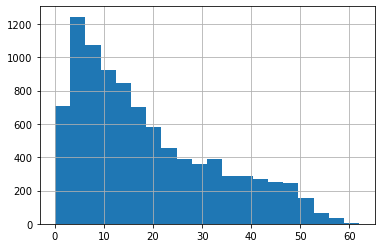

In [53]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 20)

In [68]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    padding=True,
    truncation=True
)

### Convert list to tensors

In [69]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


### Create Training and validation Set

In [70]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 8

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Print train_dataloader
print(train_dataloader)

### Define model architecture

In [71]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = True

#bert.embeddings.word_embeddings = nn.Embedding(4000,128,padding_idx=0)
#bert.pooler = nn.Linear(in_features = 768, out_features=3)
print(bert)

#model = bert


#bert.config.vocab_size = 4000
#print(bert.config.vocab_size)

# push the model to GPU
#model = model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

### Bert model

In [72]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
     
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,3)
      
      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)
      #self.softmax = nn.LogSoftmax()
      #self.sigmoid = nn.Sigmoid()
      #self.gelu = nn.GELU()
      #self.tanh = nn.Tanh()
      

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)

      x = self.fc1(cls_hs)
      
      x = self.relu(x)

      x = self.dropout(x)

      # output layer
 
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)
      #x = self.sigmoid(x)
      #x = self.gelu(x)
      #x = self.tanh(x)

      return x

In [73]:
class BERT_Arch1(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch1, self).__init__()

      self.bert = bert 
     
      # dense layer 1
      #self.fc1 = nn.Linear(768,512)

      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(768,3)
      
      #softmax activation function
      #self.softmax = nn.LogSoftmax(dim=1)
      #self.softmax = nn.LogSoftmax()
      #self.sigmoid = nn.Sigmoid()
      #self.gelu = nn.GELU()
      #self.tanh = nn.Tanh()
      

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)

      #x = self.fc1(cls_hs)
      
      # output layer
 
      x = self.fc2(cls_hs)
      
      # apply softmax activation
      #x = self.softmax(x)
      #x = self.sigmoid(x)
      #x = self.gelu(x)
      #x = self.tanh(x)

      return x

### Pass the model

In [74]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
#model = BERT_Arch1(bert)

# push the model to GPU
model = model.to(device)

### Optimizer

In [60]:
# optimizer from hugging face transformers
from torch.optim import AdamW
from torch.optim import Adam

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 2e-5)          # learning rate

### Class implementation

In [61]:
from sklearn.utils.class_weight import compute_class_weight

class_series = []
#print(train_labels)
for i in train_labels:
    value = np.argmax(i,axis=0)
    #print(value)
    class_series.append(value)

#print(class_series)


class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(class_series),
                                        y = class_series
                                    )

#class_weights = compute_class_weight(
#                                        class_weight = "balanced",
#                                        classes = np.unique(train_labels),
#                                        y = train_labels
#                                    )

print("Class Weights:",class_weights)

Class Weights: [8.417802   1.13871483 0.49924585]


### Class weight to tensor

In [62]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)
print(weights)

# push to GPU
weights = weights.to(device)

# define the loss function
#cross_entropy  = nn.CrossEntropyLoss(weight=weights) 
#cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=torch.Tensor([0,1,2]), logits=torch.Tensor([0,1,2]))
#cross_entropy = [0.6931472 ,  0.31326172 , -1.873072]
#cross_entropy = nn.CrossEntropyLoss()
#cross_entropy = nn.NLLLoss(weight=weights) 
#cross_entropy = nn.MultiLabelSoftMarginLoss(weight=weights)
#cross_entropy = nn.BCEWithLogitsLoss()
#cross_entropy = nn.BCELoss()
#print(cross_entropy)

# number of training epochs
#epochs = 10

tensor([8.4178, 1.1387, 0.4992])


In [63]:
def cross_entropy(outputs, targets):
    #return torch.nn.CrossEntropyLoss()(outputs, targets)
    #return torch.nn.MultiLabelSoftMarginLoss()
    return torch.nn.BCEWithLogitsLoss()(outputs,targets)

### Fine tune BERT

In [75]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    #batch = [r for r in batch]
 
    sent_id, mask, labels = batch
    sent_id = torch.tensor(sent_id)
   
    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)
  
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

### Evaluation Function

In [76]:
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time

# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
         
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]
    #batch = [t for t in batch]
    
    sent_id, mask, labels = batch
    sent_id = torch.tensor(sent_id)

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### Start fine tuning bert model

In [77]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

epochs = 3

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 3


C:\Users\nikhi\AppData\Local\Temp\ipykernel_20228\837280629.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_id = torch.tensor(sent_id)


  Batch    50  of  1,159.
  Batch   100  of  1,159.
  Batch   150  of  1,159.
  Batch   200  of  1,159.
  Batch   250  of  1,159.
  Batch   300  of  1,159.
  Batch   350  of  1,159.
  Batch   400  of  1,159.
  Batch   450  of  1,159.
  Batch   500  of  1,159.
  Batch   550  of  1,159.
  Batch   600  of  1,159.
  Batch   650  of  1,159.
  Batch   700  of  1,159.
  Batch   750  of  1,159.
  Batch   800  of  1,159.
  Batch   850  of  1,159.
  Batch   900  of  1,159.
  Batch   950  of  1,159.
  Batch 1,000  of  1,159.
  Batch 1,050  of  1,159.
  Batch 1,100  of  1,159.
  Batch 1,150  of  1,159.

Evaluating...


C:\Users\nikhi\AppData\Local\Temp\ipykernel_20228\4255650089.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent_id = torch.tensor(sent_id)


  Batch    50  of    249.
  Batch   100  of    249.
  Batch   150  of    249.
  Batch   200  of    249.

Training Loss: 0.397
Validation Loss: 0.513

 Epoch 2 / 3
  Batch    50  of  1,159.
  Batch   100  of  1,159.
  Batch   150  of  1,159.
  Batch   200  of  1,159.
  Batch   250  of  1,159.
  Batch   300  of  1,159.
  Batch   350  of  1,159.
  Batch   400  of  1,159.
  Batch   450  of  1,159.
  Batch   500  of  1,159.
  Batch   550  of  1,159.
  Batch   600  of  1,159.
  Batch   650  of  1,159.
  Batch   700  of  1,159.
  Batch   750  of  1,159.
  Batch   800  of  1,159.
  Batch   850  of  1,159.
  Batch   900  of  1,159.
  Batch   950  of  1,159.
  Batch 1,000  of  1,159.
  Batch 1,050  of  1,159.
  Batch 1,100  of  1,159.
  Batch 1,150  of  1,159.

Evaluating...
  Batch    50  of    249.
  Batch   100  of    249.
  Batch   150  of    249.
  Batch   200  of    249.

Training Loss: 0.346
Validation Loss: 0.547

 Epoch 3 / 3
  Batch    50  of  1,159.
  Batch   100  of  1,159.
  Batch  

In [67]:
import torch
torch.cuda.empty_cache()

In [68]:
#!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()                          

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 95% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  7% |  1% |


### Make predictions

In [69]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

RuntimeError: CUDA error: invalid argument
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

### Check performance

In [78]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()


preds = np.argmax(preds, axis = 1)
print(preds)

y_test_arg=np.argmax(test_y,axis=1)
#y_test_arg = test_y
print(y_test_arg.shape)

print(classification_report(y_test_arg, preds))


[2 1 2 ... 0 2 2]
torch.Size([1986])
              precision    recall  f1-score   support

           0       0.15      0.09      0.11        78
           1       0.56      0.61      0.58       582
           2       0.82      0.80      0.81      1326

    accuracy                           0.72      1986
   macro avg       0.51      0.50      0.50      1986
weighted avg       0.71      0.72      0.71      1986



In [79]:
# confusion matrix
pd.crosstab(y_test_arg, preds)

col_0,0,1,2
row_0,,,
0,7,33,38
1,24,355,203
2,17,247,1062


In [80]:
model.eval()
predict = model(test_seq.to(device), test_mask.to(device))
tmpMat = np.zeros((len(test_y), 3), dtype=int)

for i in range(0,len(predict)):
    if(predict[i][0] > predict[i][1] and predict[i][0] > predict[i][2]):
        tmpMat[i][0]=1
    elif(predict[i][1] > predict[i][0] and predict[i][1] > predict[i][2]):
        tmpMat[i][1]=1
    else:
        tmpMat[i][2]=1
        
print(precision_score(test_y, tmpMat, average='weighted'))
print(recall_score(test_y, tmpMat, average='weighted'))
print(f1_score(test_y, tmpMat, average='weighted'))

print(precision_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(recall_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(f1_score(test_y[:,0], tmpMat[:,0], average='weighted'))

print(precision_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(recall_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(f1_score(test_y[:,1], tmpMat[:,1], average='weighted'))

print(precision_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(recall_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(f1_score(test_y[:,2], tmpMat[:,2], average='weighted'))

RuntimeError: CUDA out of memory. Tried to allocate 146.00 MiB (GPU 0; 12.00 GiB total capacity; 10.71 GiB already allocated; 0 bytes free; 11.18 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF